# Set-Up

In [1]:
# Install requirements

!pip install -r requirements.txt

In [2]:
# Import packages
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from torchmetrics.functional import structural_similarity_index_measure as ssim
import matplotlib.pyplot as plt
import wandb
import os
import json
from torch.utils.data import Subset
import time
import yaml


# Import modules
from utils.argparse import parse_arguments
from data.dataset import LidarS2Dataset
from data.processing import compute_s2_mean_std_multi
from models.unet import ConditionalUNet
from diffusion.scheduler import LinearDiffusionScheduler, CosineDiffusionScheduler
from diffusion.sampling import p_sample_loop_ddpm, p_sample_loop_ddim, p_sample_loop_plms
from utils.metrics import compute_topographic_rmse, normalize_batch, masked_mse_loss

/cs/student/projects2/aisd/2024/tcannon/dissertation/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Set directories

s2_dir = "/cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/master_model/s2_patches_multi"
lidar_dir = "/cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/master_model/lidar_patches"

In [4]:
# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modeling Blocks

# Load in model

In [6]:
# Set config

config = {
    "system": {
        "debug": False,
        "device": "cuda" if torch.cuda.is_available() else "cpu"
    },
    "data": {
        "lidar_dir": "path/to/lidar/data",
        "s2_dir": "path/to/s2/data"
    },
    "model": {
        "base_channels": 64,
        "embed_dim": 128,
        "unet_depth": 4,
        "attention_variant": "none"
    },
    "training": {
        "context_k": 4,
        "randomize_context": True,
        "batch_size": 16,
        "num_workers": 4,
        "lr": 1e-5,
        "epochs": 100,
        "timesteps": 1000,
        "noise_schedule": "linear"
    },
    "logging": {
        "wandb_project": "your_project_name",
        "run_name": "your_run_name",
        "save_dir": "path/to/save/models"
    },
    "evaluation": {
        "eval_index_json": "path/to/eval/index.json"
    }
}

attention_flag = "att" if config["model"]["attention_variant"] != "none" else "noatt"
debug_suffix = "debug" if config["system"]["debug"] else ""
wandb_name = f"{config['logging']['run_name']}_k{config['training']['context_k']}_{attention_flag}_{f'_{debug_suffix}' if debug_suffix else ''}"
config["logging"]["wandb_name"] = wandb_name


In [ ]:
import torch
import os

# Define the path to your saved model file
# Replace this with the actual path to your saved .pth file
saved_model_path = "/cs/student/projects2/aisd/2024/tcannon/dissertation/models/baseline_hlr_k1_noatt_ddpm_best.pth" 

# Assuming your model architecture class (ConditionalUNet) and config are already defined
model = ConditionalUNet(
    in_channels=1,
    cond_channels=4 * config["training"]["context_k"],
    attr_dim=8 * config["training"]["context_k"],
    base_channels=config["model"]["base_channels"],
    embed_dim=config["model"]["embed_dim"],
    unet_depth=config["model"]["unet_depth"],
    attention_variant=config["model"]["attention_variant"]
)

# Load the saved state dictionary
try:
    checkpoint = torch.load(saved_model_path, map_location='cpu') # Use 'cpu' if you don't have a GPU
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Model successfully loaded from {saved_model_path}")

    # Set the model to evaluation mode
    model.eval()
    print("Model set to evaluation mode.")

    # Now you can use the loaded 'model' for reconstruction or evaluation
    # For example:
    # with torch.no_grad():
    #     pred = p_sample_loop_ddim(model, scheduler, shape, cond, attrs, device)
    
except FileNotFoundError:
    print(f"Error: The model file was not found at {saved_model_path}")

In [17]:
# Get model size in parameters

def get_model_size(model):
    return sum(p.numel() for p in model.parameters())

model_size = get_model_size(model)
print("Model size (parameters):", model_size)


Model size (parameters): 59523713


# Evaluation

In [8]:
# =============================================================================
# RECONSTRUCTION EVALUATION
# =============================================================================

def run_reconstruction_evaluation(model, val_dataset, config, scheduler=None):
    """Run reconstruction evaluation with S2 selection and error map visualization (dynamic k)."""
    print("\n" + "="*60)
    print("RUNNING RECONSTRUCTION EVALUATION")
    print("="*60)

    # Force evaluation mode and fixed eval indices if available
    if hasattr(val_dataset, "dataset"):
        val_dataset.dataset.split = "val"
        # FIX: Access from evaluation section
        eval_json = config["evaluation"]["eval_index_json"]
        if eval_json and os.path.exists(eval_json):
            with open(eval_json, "r") as f:
                val_dataset.dataset.eval_patch_order = json.load(f)

    # FIX: Access from logging section
    output_dir = config["logging"]["output_dir"]
    os.makedirs(output_dir, exist_ok=True)
    model.eval()

    torch.manual_seed(42)
    # FIX: Access from training section
    val_loader = DataLoader(val_dataset, batch_size=config["training"]["batch_size"], shuffle=False)
    batch = next(iter(val_loader))

    # FIX: Access from system section
    s2    = batch["s2"].to(config["system"]["device"])          # [B, k*4, Hc, Wc]
    lidar = batch["lidar"].to(config["system"]["device"])       # [B, 1, H, W]
    attrs = batch["attrs"].to(config["system"]["device"])       # [B, k*8]
    mask  = batch["mask"].to(config["system"]["device"])        # [B, H, W]
    B = lidar.size(0)

    # FIX: Access from training section
    context_k = config["training"]["context_k"]                     
    # FIX: Access from logging section
    run_name = config["logging"]["run_name"]
    model_type = model.__class__.__name__

    # Add sampling time tracking
    # wandb.define_metric("sampling_time_sec", summary="min")

    # Samplers
    all_samplers = {
        "ddpm": lambda m, s, c, a, d: p_sample_loop_ddpm(m, scheduler, s, c, a, d) if scheduler else None,
        "ddim": lambda m, s, c, a, d: p_sample_loop_ddim(m, scheduler, s, c, a, d) if scheduler else None,
        "plms": lambda m, s, c, a, d: p_sample_loop_plms(m, scheduler, s, c, a, d) if scheduler else None,
    }
    # FIX: Access from evaluation section
    requested_methods = config["evaluation"]["sampling_methods"]
    p_samplers = {m: all_samplers[m] for m in requested_methods if m in all_samplers}
    if not p_samplers:
        print("No valid samplers available")
        return

    # Try to retrieve which t{i} were used (optional; may not exist)
    used_patch_ids = getattr(getattr(val_dataset, "dataset", val_dataset), "last_patch_indices", None)
    # If present and per-batch, expect a list-of-lists with length B; otherwise we ignore

    for sampler_name, sampler_func in p_samplers.items():
        print(f"\nSampling method: {sampler_name}")

        with torch.no_grad():
            # Start timing
            torch.cuda.synchronize()  # Ensure all GPU operations are finished
            start_time = time.perf_counter()
            # FIX: Access from system section
            pred = sampler_func(model, lidar.shape, s2, attrs, config["system"]["device"])
            # End timing
            torch.cuda.synchronize()  # Wait for the generation to complete
            end_time = time.perf_counter()
            sampling_time = end_time - start_time

            # Log the sampling time to WandB
            # if wandb.run:
                # wandb.log({f"{sampler_name}_sampling_time_sec": sampling_time})

            # Move items to CPU
            gt = lidar.cpu()
            pred = pred.cpu()
            mask_cpu = mask.cpu()

            # Normalize for SSIM and viz
            gt_norm = normalize_batch(gt)
            pred_norm = normalize_batch(pred)
            abs_error = (gt - pred).abs()

            # Safe normalization for error map
            err_max = abs_error.amax(dim=(1,2,3), keepdim=True)
            err_norm = abs_error / (err_max + 1e-8)
            s2_cpu = s2.cpu()

            # Per-tile metrics
            mae_tile  = F.l1_loss(pred, gt, reduction='none').mean(dim=(1, 2, 3)).tolist()
            rmse_tile = ((pred - gt) ** 2).mean(dim=(1, 2, 3)).sqrt().tolist()
            ssim_tile = [ssim(pred_norm[i:i+1], gt_norm[i:i+1], data_range=1.0).item() for i in range(B)]
            topo_tile = [compute_topographic_rmse(gt[i:i+1], pred[i:i+1]).item() for i in range(B)]
            
            # --- ADDED Roughness metric ---
            rough_tile = [abs(torch.std(gt[i]) - torch.std(pred[i])).item() for i in range(B)]

            # Aggregated metrics
            mae = float(np.mean(mae_tile))
            rmse = float(np.mean(rmse_tile))
            ssim_avg = float(np.mean(ssim_tile))
            topo_avg = float(np.mean(topo_tile))
            
            # --- ADDED Roughness aggregation ---
            rough_avg = float(np.mean(rough_tile))
            """
            if wandb.run:
                wandb.log({
                    f"{sampler_name}_mae": mae,
                    f"{sampler_name}_rmse": rmse,
                    f"{sampler_name}_ssim": ssim_avg,
                    f"{sampler_name}_topographic_rmse": topo_avg,
                    f"{sampler_name}_roughness": rough_avg,  # Log new metric
                })
            """
            # Build visualization tensors
            gt_rgb   = gt_norm.repeat(1, 3, 1, 1)
            pred_rgb = pred_norm.repeat(1, 3, 1, 1)
            err_rgb  = err_norm.repeat(1, 3, 1, 1)

            # Rebuild S2 RGB stacks dynamically for available times (k)
            s2_rgb_times = []
            num_times = s2_cpu.shape[1] // 4
            for t_idx in range(num_times):
                base = t_idx * 4
                # pick R,G,B from [base, base+1, base+2]
                rgb = s2_cpu[:, [base, base+1, base+2], ...]
                rgb = normalize_batch(rgb)
                rgb = F.interpolate(rgb, size=gt.shape[-2:], mode="bilinear", align_corners=False)
                s2_rgb_times.append(rgb)

            # Create the tiled image
            # FIX: Access from training section
            Bvis = min(config["training"]["batch_size"], B)
            tiles = []
            for i in range(Bvis):
                # Stack available S2 times, then GT, Pred, Error → (num_times + 3 rows)
                rows = [s2_rgb_times[t][i] for t in range(num_times)] + [gt_rgb[i], pred_rgb[i], err_rgb[i]]
                tile = torch.cat(rows, dim=1)  # concat along height
                tiles.append(tile)

            full_image = torch.cat(tiles, dim=2)  # concat along width
            img_np = full_image.permute(1, 2, 0).numpy()

            # Plot
            fig_h = 18 if num_times <= 3 else 22
            fig, ax = plt.subplots(figsize=(42, fig_h))
            ax.axis("off")
            ax.imshow(img_np)

            # Row labels
            row_labels = [f"S2 t{t}" for t in range(num_times)] + ["GT", "Pred", "|Error|"]
            row_height = img_np.shape[0] // len(row_labels)
            for r, label in enumerate(row_labels):
                y = r * row_height + row_height // 2
                ax.text(-10, y, label, ha="right", va="center", fontsize=13, fontweight='bold',
                        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

            # Per-tile text & highlight used t{i} (if available)
            tile_width = img_np.shape[1] // Bvis
            for i in range(Bvis):
                x = i * tile_width + 5
                # Metrics beside each tile
                metrics = (f"MAE: {mae_tile[i]:.3f}\n"
                           f"RMSE: {rmse_tile[i]:.3f}\n"
                           f"SSIM: {ssim_tile[i]:.3f}\n"
                           f"Topo: {topo_tile[i]:.3f}\n"
                           f"Rough: {rough_tile[i]:.3f}")  # ADDED roughness to visualization
                ax.text(x, img_np.shape[0] + 10, metrics, ha='left', va='top',
                        fontsize=12, bbox=dict(facecolor='white', alpha=0.85, boxstyle='round'))

                # Highlight the specific t{i} rows that were used for this sample (if known)
                if used_patch_ids is not None and i < len(used_patch_ids):
                    chosen = used_patch_ids[i]  # list of absolute t-indices (e.g., [0,3,5])
                    # Map those to the rows we actually drew (0..num_times-1)
                    for r in chosen:
                        if 0 <= r < num_times:  # only highlight if that row exists in this viz
                            y0 = r * row_height
                            ax.add_patch(plt.Rectangle(
                                (x, y0), tile_width - 10, row_height,
                                edgecolor='red', linewidth=2, facecolor='none'
                            ))

            # Footer with aggregated metrics
            footer = (f"Mean → MAE: {mae:.3f} | RMSE: {rmse:.3f} | SSIM: {ssim_avg:.3f} | Topo RMSE: {topo_avg:.3f} | "
                      f"Roughness: {rough_avg:.3f}")  # ADDED roughness to footer
            ax.text(img_np.shape[1] // 2, img_np.shape[0] + 120, footer,
                    ha='center', fontsize=16, weight='bold', color='darkblue')

            plt.tight_layout()
            # Access name from logging section
            out_name = config["logging"]["wandb_name"] or config["logging"]["run_name"]
            out_path = os.path.join(config["logging"]["output_dir"], f"{out_name}_{sampler_name}_vis.png")
            fig.savefig(out_path, dpi=150, bbox_inches='tight')
            plt.close()
            print(f"Saved visualization to {out_path}")

In [27]:
# Linear Diffusion Scheduler
class DiffusionScheduler:
    def __init__(self, timesteps=1000, beta_start=1e-4, beta_end=0.02, device='cuda'):
        self.timesteps = timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, timesteps).to(device)

        self.alphas = 1. - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alpha_cumprod_prev = torch.cat([torch.tensor([1.], device=device), self.alpha_cumprod[:-1]])

        self.sqrt_alpha_cumprod = torch.sqrt(self.alpha_cumprod)
        self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - self.alpha_cumprod)

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        sqrt_alpha = self.sqrt_alpha_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha = self.sqrt_one_minus_alpha_cumprod[t].view(-1, 1, 1, 1)
        return sqrt_alpha * x_start + sqrt_one_minus_alpha * noise
    
# Set scheduler
scheduler = DiffusionScheduler(timesteps=config["timesteps"], device=config["device"])


RUNNING RECONSTRUCTION EVALUATION

Sampling method: ddpm
Metric               | LiDAR RANSAC Residuals
-------------------------------------------------------
MAE                  |     0.0864     
RMSE                 |     0.1112     
Normalized RMSE (%)  |      10.79      
SSIM                 |     0.1584      
Topographic RMSE     |     0.0585      |        -       


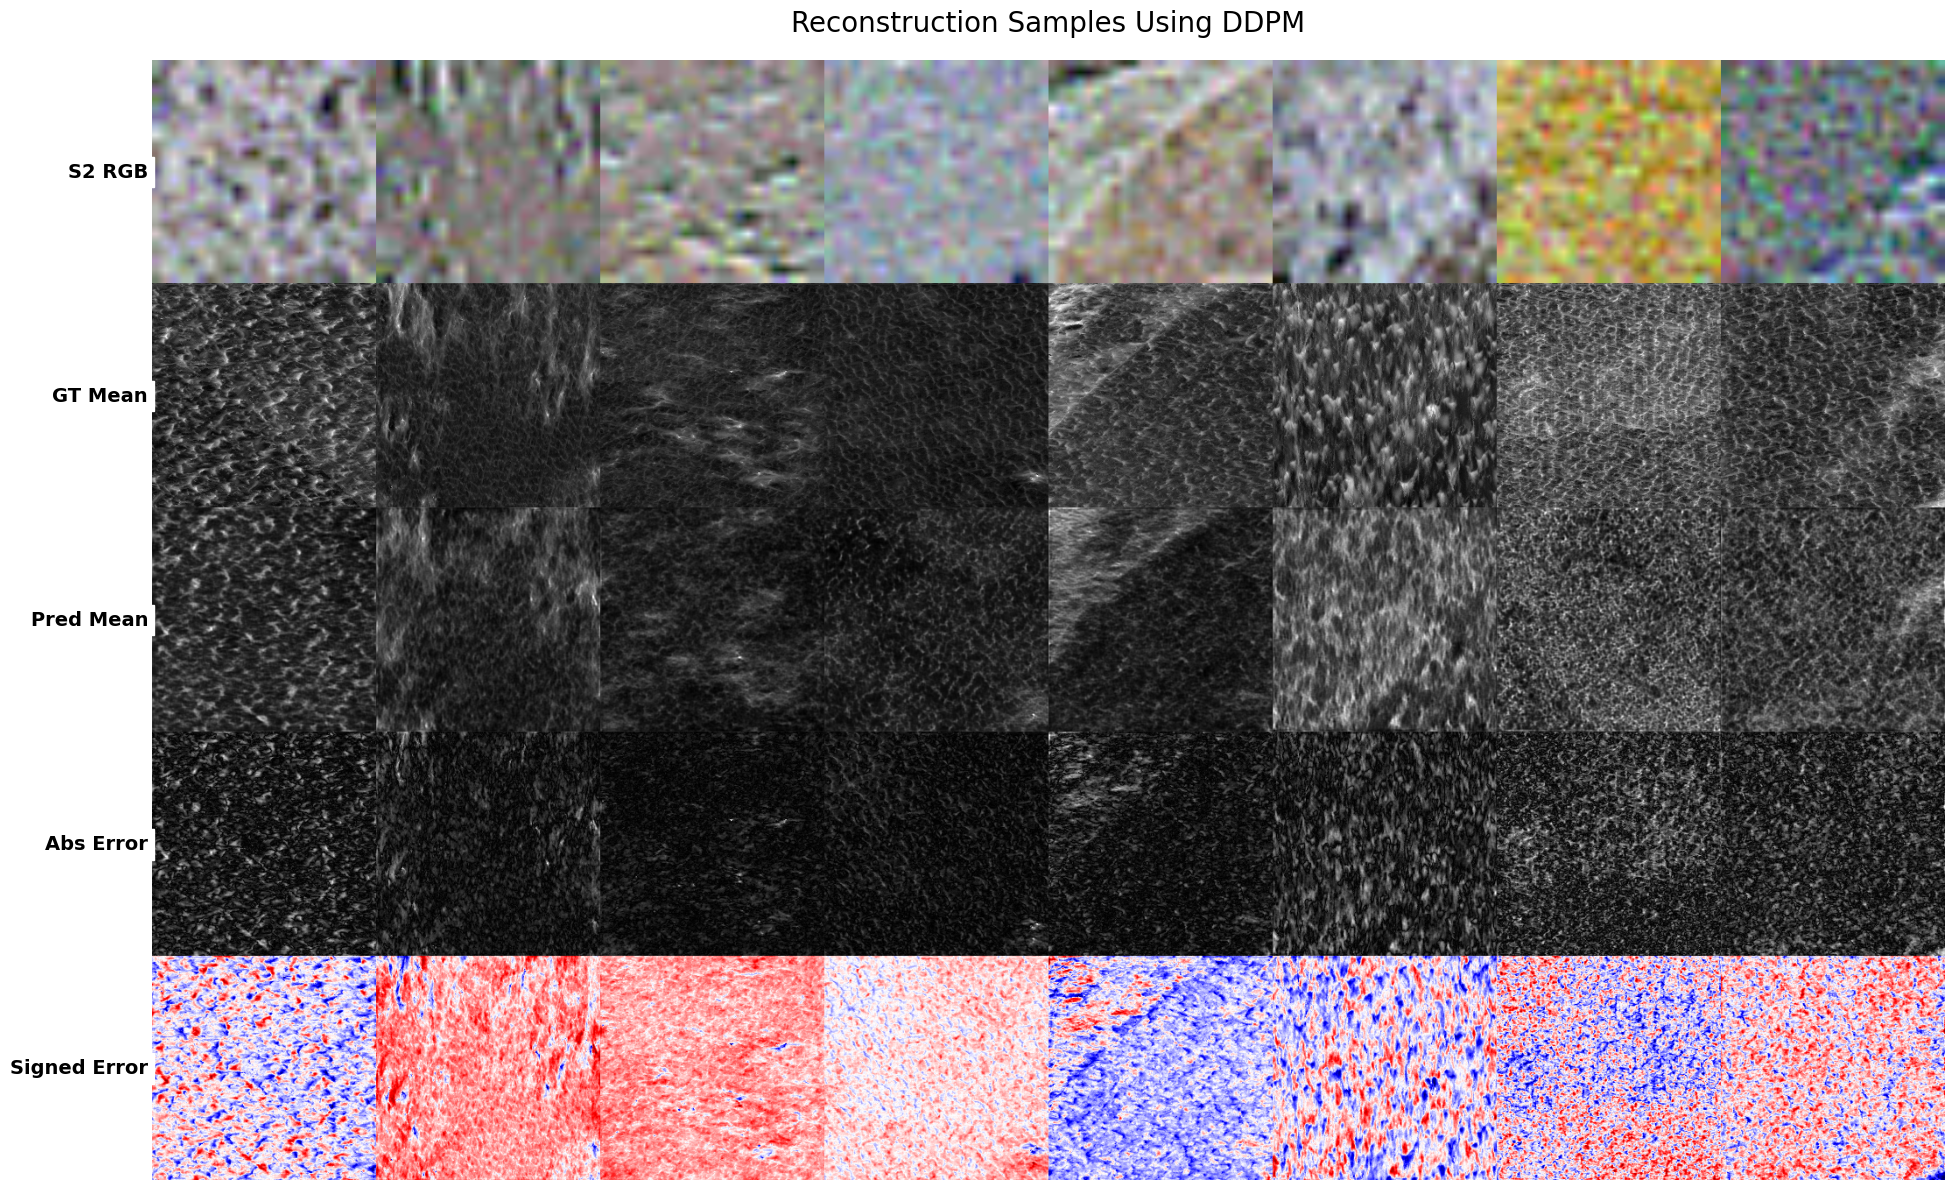


Sampling method: ddim


In [ ]:
# Run evaluation

run_reconstruction_evaluation(model, test_dataset, config, scheduler)

In [31]:
# Create configuration dictionary from arguments
config = {
    "s2_dir": s2_dir,
    "lidar_dir": lidar_dir,
    "batch_size": 8,
    "device": device,
    "sampling_methods": ['edm_heun','edm_euler'],
    "evaluate": True,
    "edm": True,
    "timesteps":1000
}


RUNNING RECONSTRUCTION EVALUATION

Sampling method: edm_heun
Metric               | Mean Elevation  |  Std Elevation 
-------------------------------------------------------
MAE                  |     0.0802      |     0.0470     
RMSE                 |     0.1030      |     0.0595     
Normalized RMSE (%)  |      7.32       |      1.29      
SSIM                 |     0.1640      |     0.0346     
Topographic RMSE     |     0.1153      |        -       


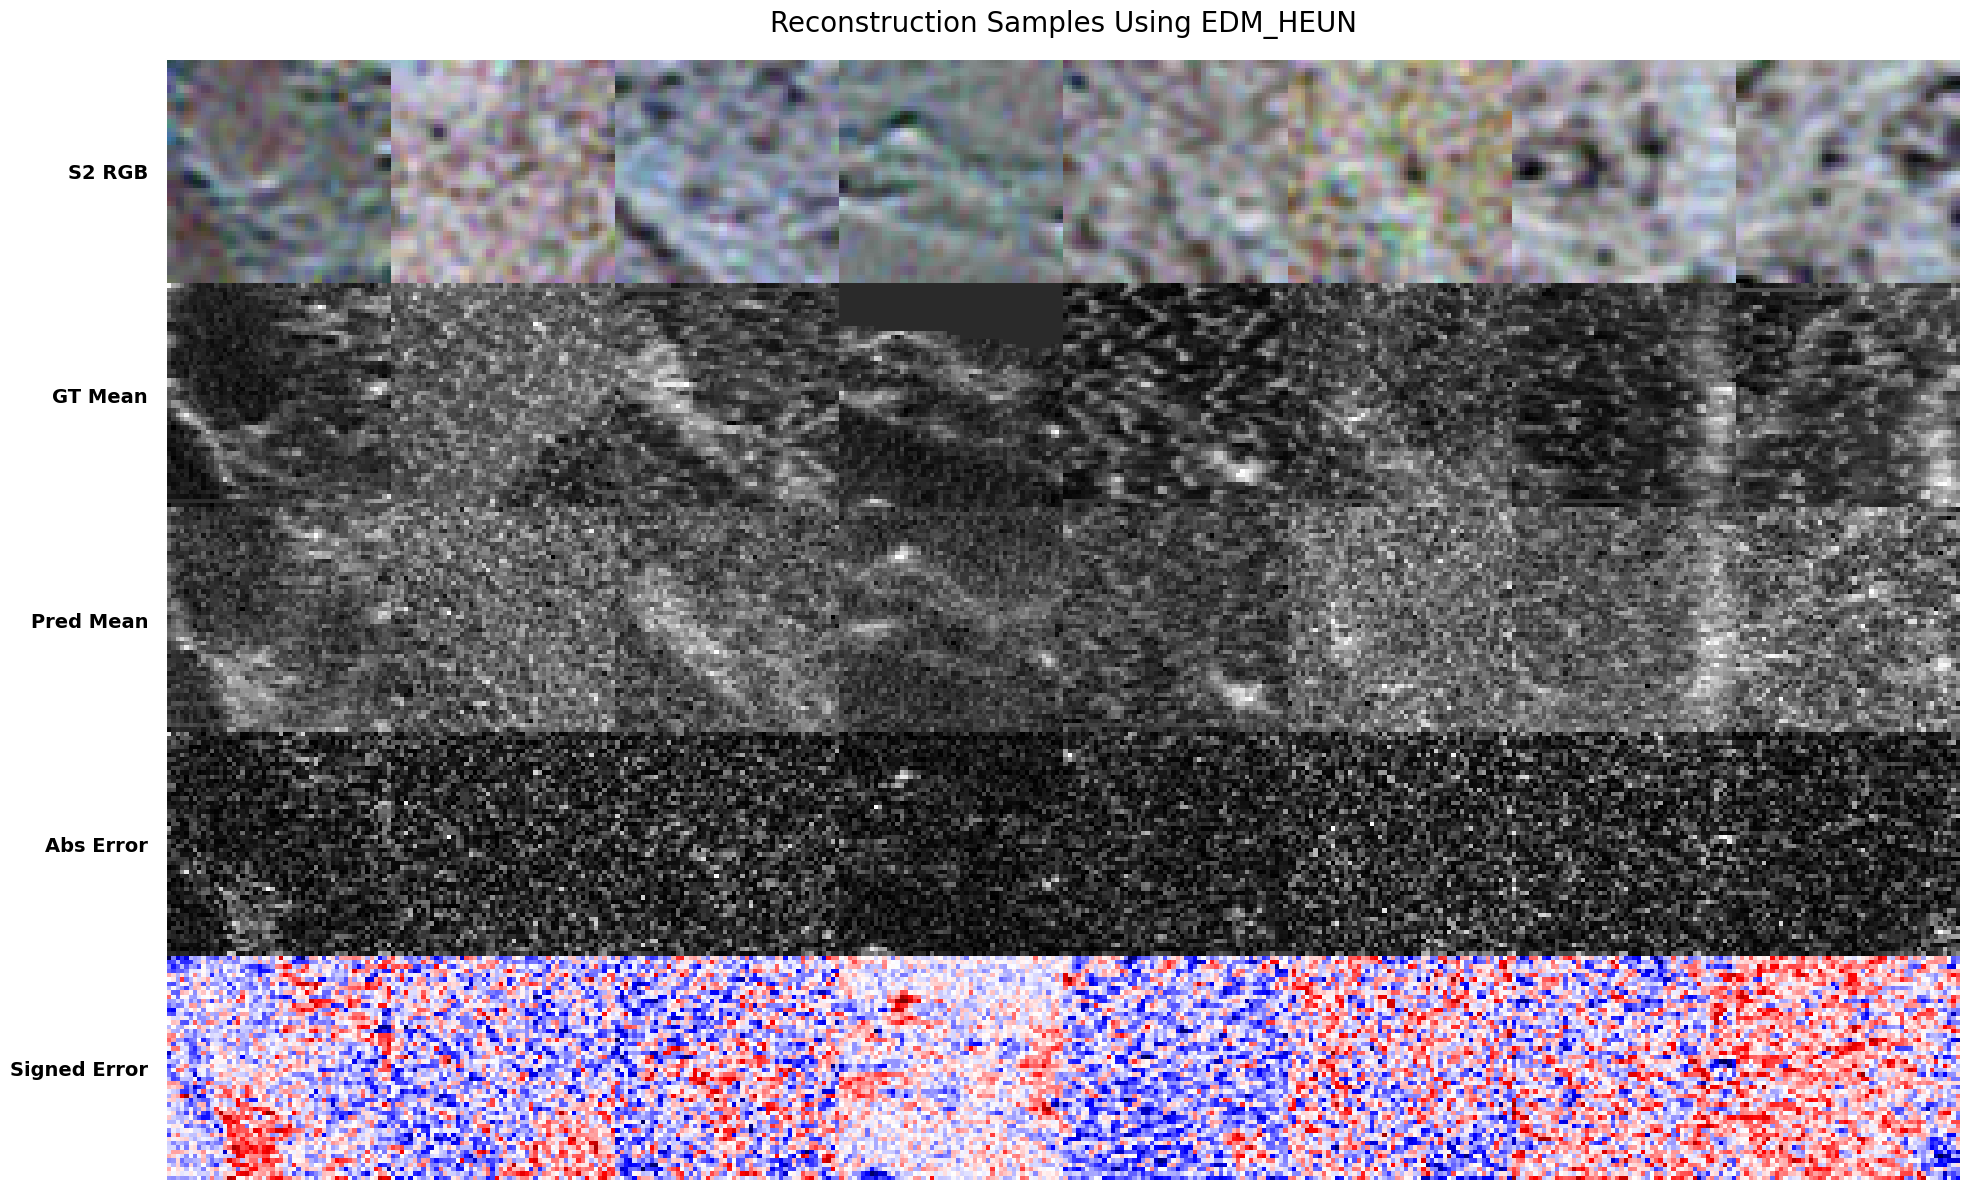


Sampling method: edm_euler
Metric               | Mean Elevation  |  Std Elevation 
-------------------------------------------------------
MAE                  |     0.0833      |     0.0489     
RMSE                 |     0.1067      |     0.0619     
Normalized RMSE (%)  |      7.58       |      1.35      
SSIM                 |     0.1671      |     0.0351     
Topographic RMSE     |     0.1179      |        -       


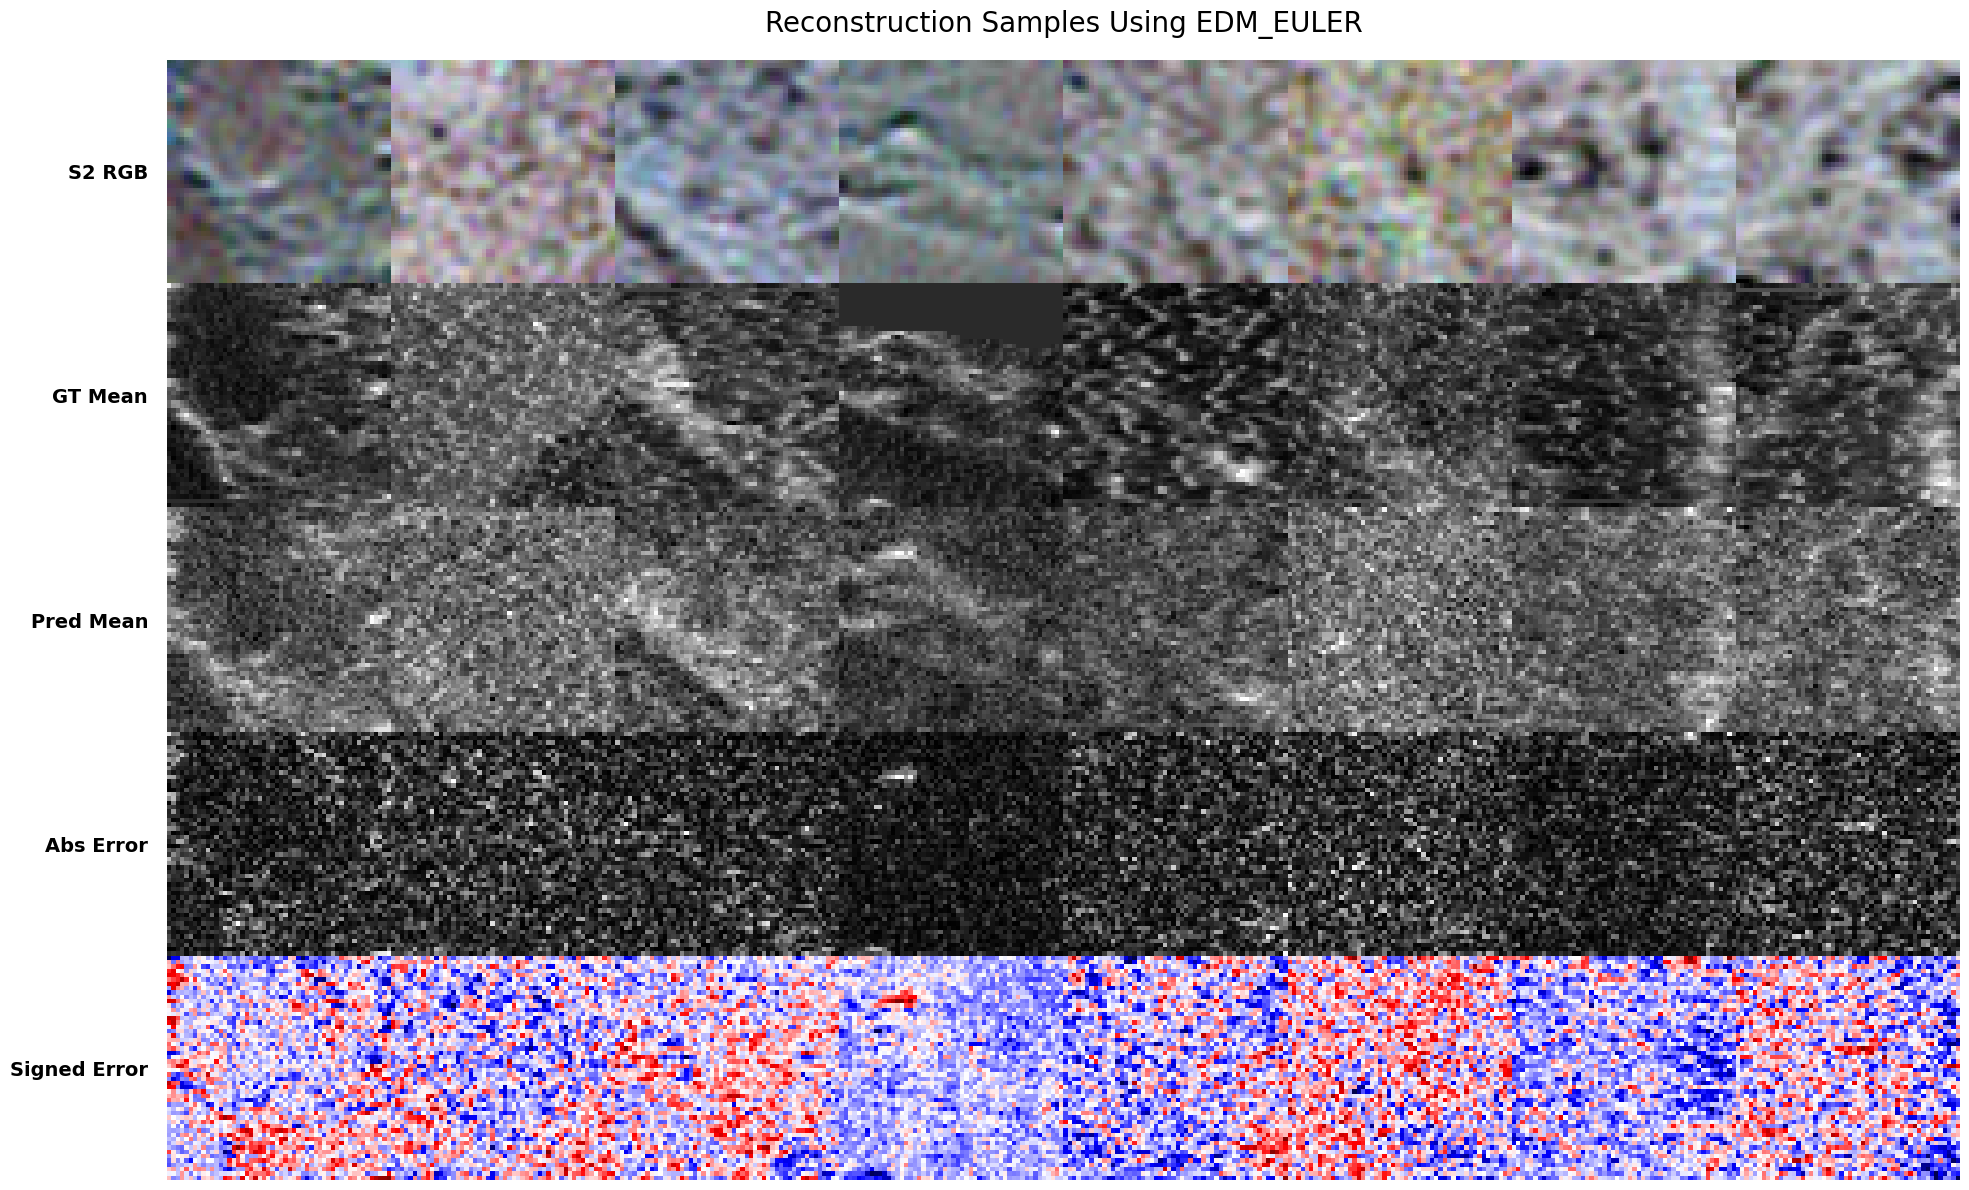

In [32]:
# Run evaluation

run_reconstruction_evaluation(model, test_dataset, config, scheduler)

# Master Evaluation

In [12]:
def run_reconstruction_evaluation(model, val_dataset, config, scheduler=None):
    """Run reconstruction evaluation with specified sampling methods."""
    print("\n" + "="*60)
    print("RUNNING RECONSTRUCTION EVALUATION")
    print("="*60)
    
    
    # Set model to eval
    model.eval()
    
    # Extract sample batch from the validation set (consistent seed for reproducibility)
    torch.manual_seed(42)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    batch = next(iter(val_loader))
    s2 = batch["s2"].to(config["device"])
    lidar = batch["lidar"].to(config["device"])
    attrs = batch["attrs"].to(config["device"])  # <-- NEW
    
    
    # Determine if we're using EDM or standard model
    is_edm = hasattr(model, 'get_scalings')
    
    # Define available sampling methods
    all_samplers = {
        "ddpm":     (lambda m, s, c, a, d: p_sample_loop_ddpm(m, scheduler, s, c, a, d) if scheduler else None),
        "ddim":     (lambda m, s, c, a, d: p_sample_loop_ddim(m, scheduler, s, c, a, d) if scheduler else None),
        "plms":     (lambda m, s, c, a, d: p_sample_loop_plms(m, scheduler, s, c, a, d) if scheduler else None),
        "edm_euler":(lambda m, s, c, a, d: edm_sample_euler(m, s, c, a, d) if is_edm else None),
        "edm_heun": (lambda m, s, c, a, d: edm_sample_heun (m, s, c, a, d) if is_edm else None),
    }

    # Filter samplers based on model type and user selection
    requested_methods = config.get("sampling_methods", ["edm_heun"])
    p_samplers = {}
    
    for method in requested_methods:
        if method in all_samplers and all_samplers[method] is not None:
            # Test if the method is compatible
            if method.startswith('edm') and not is_edm:
                print(f"Warning: {method} not available for non-EDM models, skipping...")
                continue
            elif not method.startswith('edm') and scheduler is None:
                print(f"Warning: {method} requires scheduler, skipping...")
                continue
            p_samplers[method] = all_samplers[method]
        else:
            print(f"Warning: {method} not available, skipping...")
    
    if not p_samplers:
        print("No valid sampling methods available!")
        return
    
    # Get run info
    run_name = config.get("run_name", "default_run")
    model_type = model.__class__.__name__

    # Which S2 time to visualize (0..5)
    vis_time_idx = int(config.get("vis_time_idx", 0))
    vis_time_idx = max(0, min(vis_time_idx, 5))
    # channels per time = 4 (R,G,B,NIR), visualize RGB as (R,G,B)
    start = vis_time_idx * 4
    rgb_idx = [start + 0, start + 1, start + 2]  # R,G,B order in your stack
    
    # Perform evaluation for each sampling method
    for sampler_name, sampler_func in p_samplers.items():
        print(f"\nSampling method: {sampler_name}")
        
        with torch.no_grad():
            # Generate samples
            generated = sampler_func(model, lidar.shape, s2, attrs, config["device"])  # <<< attrs added
            
            # Extract raw tensors
            gt = lidar.cpu()
            pred = generated.cpu()

            # MAE & RMSE in meters
            mae = F.l1_loss(pred, gt).item()
            rmse = F.mse_loss(pred, gt).sqrt().item()

            # Normalized RMSE by mean elevation
            nrmse = rmse / gt.mean().item()

            # Topographic RMSE
            topo_rmse = compute_topographic_rmse(gt, pred).item()

            # Normalize to [0, 1] for SSIM and visualization
            gt_norm = normalize_batch(gt)
            pred_norm = normalize_batch(pred)

            # SSIM
            ssim_lidar = ssim(pred_norm, gt_norm, data_range=1.0).item()

            # Print results
            print(f"{'Metric':<20} | {'LiDAR RANSAC Residuals':^15}")
            print("-" * 55)
            print(f"{'MAE':<20} | {mae:^15.4f}")
            print(f"{'RMSE':<20} | {rmse:^15.4f}")
            print(f"{'Normalized RMSE (%)':<20} | {nrmse:^15.2f} ")
            print(f"{'SSIM':<20} | {ssim_lidar:^15.4f} ")
            print(f"{'Topographic RMSE':<20} | {topo_rmse:^15.4f} | {'-':^15}")


            # Reconstruction Visualization
            # Normalize GT/Pred (already done above) and convert LiDAR (1ch) → RGB for display
            gt_elev   = gt_norm[:, :1, :, :]        # [B,1,H,W]
            pred_elev = pred_norm[:, :1, :, :]      # [B,1,H,W]
            gt_rgb    = gt_elev.repeat(1, 3, 1, 1)  # [B,3,H,W]
            pred_rgb  = pred_elev.repeat(1, 3, 1, 1)# [B,3,H,W]

            # Build RGB for all six S2 times: t0..t5 as (R,G,B) = (ch+0, ch+1, ch+2)
            # s2 is [B,24,Hc,Wc] with times packed as 6×4 bands
            s2_rgb_times = []
            for t_idx in range(6):
                base = t_idx * 4
                rgb = s2[:, [base + 0, base + 1, base + 2], ...].cpu()      # [B,3,Hc,Wc]
                rgb = normalize_batch(rgb)                                   # [B,3,Hc,Wc]
                rgb = F.interpolate(rgb, size=gt_norm.shape[-2:], mode="bilinear", align_corners=False)  # → [B,3,H,W]
                s2_rgb_times.append(rgb)

            # Take the first 8 samples to visualize
            Bvis = min(8, gt_rgb.size(0))
            tiles = []
            for i in range(Bvis):
                # Stack 6 S2 times vertically, then GT and Pred → total 8 rows
                rows = [s2_rgb_times[t][i] for t in range(6)] + [gt_rgb[i], pred_rgb[i]]  # each [3,H,W]
                tile = torch.cat(rows, dim=1)  # concat along height → [3, 8H, W]
                tiles.append(tile)

            # Concatenate samples horizontally
            final_grid = torch.cat(tiles, dim=2)  # [3, 8H, Bvis*W]
            img = final_grid.permute(1, 2, 0).numpy()

            plt.figure(figsize=(40, 16))
            plt.imshow(img)
            plt.title(f"Reconstruction Samples Using {sampler_name.upper()} (S2 t0..t5, GT, Pred)", fontsize=20, pad=20)
            plt.axis("off")

            # Optional left-side row labels
            row_labels = [f"S2 t{t}" for t in range(6)] + ["GT LiDAR", "Pred LiDAR"]
            row_height = img.shape[0] // len(row_labels)
            for ridx, label in enumerate(row_labels):
                y = ridx * row_height + row_height // 2
                plt.text(-5, y, label, va='center', ha='right', fontsize=14,
                        fontweight='bold', color='black', backgroundcolor='white')

            plt.tight_layout()

            # Show the plot
            plt.show()
    

In [ ]:
# Create configuration dictionary from arguments
config = {
    "s2_dir": s2_dir,
    "lidar_dir": lidar_dir,
    "batch_size": 8,
    "device": device,
    "sampling_methods": ['ddim','ddpm','plms'],
    "evaluate": True,
    "edm": False,
    "timesteps":1000
}

# Set directories

s2_dir = "/cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/master_model/s2_patches_multi"
lidar_dir = "/cs/student/projects2/aisd/2024/tcannon/dissertation/Dissertation/master_model/lidar_patches"

In [18]:
# Run evaluation

run_reconstruction_evaluation(model, test_dataset, config, scheduler)


RUNNING RECONSTRUCTION EVALUATION

Sampling method: ddim


OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 GiB. GPU 0 has a total capacity of 23.54 GiB of which 1.74 GiB is free. Including non-PyTorch memory, this process has 21.77 GiB memory in use. Of the allocated memory 19.29 GiB is allocated by PyTorch, and 2.03 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)